# This notebook reads text data from data extract created from FSHA Forms and runs predictive Models to predict the value 'Are there any inherent or cross contact allergens or intolerants?' , based on the Input Data
# It does vectorization of each Column and concatenates these Vectors to create a final Feature Vector and fits multiple ML Models, including Deep Learning model

In [50]:
#import all necessary modules
from __future__ import print_function
import logging
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt
import os
import nltk
import string
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize import RegexpTokenizer
import re
import numpy as np
from numpy import array
from numpy import argmax
from scipy import signal
import random
import string
import pandas as pd
from sklearn.model_selection import train_test_split 
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import f_classif
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix  
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC 
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.utils.extmath import density
from sklearn.decomposition import PCA
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.keras import models
from tensorflow.python.keras import initializers
from tensorflow.python.keras import regularizers
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import Dropout
import warnings
warnings.simplefilter('ignore')

In [51]:
tf.__version__

'1.14.0'

In [53]:
import sklearn
print(sklearn.__version__)

0.19.0


## File name and other important parameters like ngram_range set

In [2]:
#These parameters will be input from command line
ngram_range_inp=(1,2)
filename = "C:/Pepsico/FSHA RPA - 23 July 2019.xlsm"

# Define reusable modular method for Text Normalization (removal of stopwords, changing to lower case, removal of punctuation etc) 

In [3]:
exclude = set(string.punctuation) 
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
newStopWords = ['from','dtype','object']
stop_words.extend(newStopWords)
table = str.maketrans('', '', string.punctuation)

porter = PorterStemmer()

def normalize_document(doc):
    # tokenize document
    tokens = doc.split()
    # remove punctuation from each word
    tokens = [w.translate(table) for w in tokens]
    # convert to lower case
    lower_tokens = [w.lower() for w in tokens]
    #remove spaces
    stripped = [w.strip() for w in lower_tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter stopwords out of document
    filtered_tokens = [token for token in words if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

#normalize_corpus = np.vectorize(normalize_document)

In [4]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
import re
from bs4 import BeautifulSoup
import unicodedata

tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text):
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    return text

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=True, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True):
    
    normalized_corpus = []
    # normalize each document in the corpus
    #corpus = str(corpus)
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)

        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        # remove special characters    
        if special_char_removal:
            doc = remove_special_characters(doc)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
            
        normalized_corpus.append(doc)
        
    return normalized_corpus

In [5]:
def clean_doc(corpus):
    normalized_corpus = []
    # normalize each document in the corpus
    #corpus = str(corpus)
    for doc in corpus:
	# split into tokens by white space
        doc=str(doc)
        doc = doc.replace('\n',' ')
        tokens = doc.split()
        # prepare regex for char filtering
        re_punc = re.compile('[%s]' % re.escape(string.punctuation))
        # remove punctuation from each word
        tokens = [re_punc.sub('', w) for w in tokens]
        # remove remaining tokens that are not alphabetic
        tokens = [word for word in tokens if word.isalpha()]
        # filter out stop words
        tokens = [w for w in tokens if not w in stop_words]
        # filter out short tokens
        tokens = [word for word in tokens if len(word) > 1]
        # remove nn from each word
        tokens = [re.sub('nn',' ',word) for word in tokens]
        tokens = ' '.join(tokens)
        normalized_corpus.append(tokens)
    return normalized_corpus

# Read the data extract file (tabular format with Input data(X) and target(Y))

In [6]:
fsha_data = pd.read_excel(filename)

In [7]:
len(fsha_data)

167

In [8]:
fsha_data.head()

,File Name,projName,accolNumber,PDA_projName,projType,projDesc,formulaNumber,owner,sector,center,...,Table1_Row6_Molluscs,Table1_Row6_Mustard,Table1_Row6_Sesame Seeds,Table1_Row6_Sulphites,Table1_Row1_Moulluscs,Table1_Row2_Moulluscs,Table1_Row3_Moulluscs,Table1_Row4_Moulluscs,Table1_Row5_Moulluscs,Table1_Row6_Moulluscs
0,#46565 FSHA 5.4.1Star Project G3 v2 + FS input...,S-T3-Star-• POL Star Puff (Chrupki) quality –POL,46565,1SKU Star Puffs Onion\n2 SKU Star Puffs Cheese...,Brand Refresh,Star Puffs Cheese & STar Hyper Cheese\nSeasoni...,NaN,Weronika Baranowska,ESSA,Warsaw,...,0.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,#53697 FSHA HT Baguette 4 Cheese UA 2.07.19.xlsm,HT Baguette Four Cheese Flavor,53697,Hrusteam Baguette,Refresh,Launch new seasoning 4 Cheese NL-502-352-9 on ...,NaN,Anna Nikonova,ESSA,Moscow,...,0.0,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,#57686 FSHA 5.4.1 Red Caviar Azov.xlsm,Lay's Caviar IO 2019 RUS Asov,57686,Lay's Red Caviar,Refresh,Idea is to launch I&O flavour under New Year p...,Not provided,Evgeniy Shklovskiy +79163257848,ESSA,Moscow,...,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,#57686 FSHA 5.4.1 Red Caviar Kashira.xlsm,Lay's Caviar IO 2019 RUS Kashira,57686,Lay's Red Caviar,Refresh,Idea is to launch I&O flavour under New Year p...,Not provided,Evgeniy Shklovskiy +79163257848,ESSA,Moscow,...,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,53354-FSHA-In Process 13.12.18.xlsm,Soft and Mild Iberia 2019,53354,Cheetos Palomito,Re Launch,"Re Launch of Cheetos Palomitos, Soft Extruded ...",CP2019,David Labrado 07770646572,ESSA,Beaumont Park,...,0.0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


# Based on Analysis select the Features (X)

In [9]:
#selecting set of columns as Features
features_df=fsha_data[['preservatives', 'pH', 'waterActivity', 'packaging','otherFSA',
            'prodStorageDist', 'foodSafetyProdClaims','targetMarket','allergens','newIngredient','allergensLabeledIMAF']]

# Replace missing values in features with NA

In [10]:
features_df.fillna('NA', inplace=True)

In [11]:
train_df = features_df

# Define reusable code to Vectorize Text column (ex: Allergens) using TF-IDF Vectorizer, after doing Text data normalization

In [12]:
# Vectorization of text data using TF-IDF Vectorizer

# Range (inclusive) of n-gram sizes for tokenizing text.
#NGRAM_RANGE 

# Limit on the number of features. We use the top 20K features.
#TOP_K = 20000

# Whether text should be split into word or character n-grams.
# One of 'word', 'char'.
TOKEN_MODE = 'word'

# Minimum document/corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 2

# Limit on the length of text sequences. Sequences longer than this
# will be truncated.
MAX_SEQUENCE_LENGTH = 500


def ngram_vectorize(train_texts, train_labels,ngram_range):
    """Vectorizes texts as ngram vectors.

    1 text = 1 tf-idf vector the length of vocabulary of uni-grams + bi-grams.

    # Arguments
        train_texts: list, training text strings.
        train_labels: np.ndarray, training labels.
        val_texts: list, validation text strings.

    # Returns
        x_train, x_val: vectorized training and validation texts
    """
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
            'ngram_range': ngram_range,  # Use 1-grams + 2-grams.
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': TOKEN_MODE,  # Split text into word tokens.
            'min_df': MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    x_train = x_train.astype('float32')
    return x_train

In [13]:
train_df.columns

Index(['preservatives', 'pH', 'waterActivity', 'packaging', 'otherFSA',
       'prodStorageDist', 'foodSafetyProdClaims', 'targetMarket', 'allergens',
       'newIngredient', 'allergensLabeledIMAF'],
      dtype='object')

# Normalize each column , by cleaning the text

In [14]:
train_df['norm_preservatives'] = normalize_corpus(train_df['preservatives'])
train_df['norm_pH'] = normalize_corpus(train_df['pH'])
train_df['norm_waterActivity'] = clean_doc(train_df['waterActivity'])
train_df['norm_packaging'] = normalize_corpus(train_df['packaging'])
train_df['norm_otherFSA'] = normalize_corpus(train_df['otherFSA'])
train_df['norm_prodStorageDist'] = normalize_corpus(train_df['prodStorageDist'])
train_df['norm_foodSafety_prodClaims'] = normalize_corpus(train_df['foodSafetyProdClaims'])
train_df['norm_targetMarket'] = normalize_corpus(train_df['targetMarket'])
train_df['norm_newIngredient'] = normalize_corpus(train_df['newIngredient'])
train_df['norm_allergens'] = normalize_corpus(train_df['allergens'])
train_df['norm_allergens_M']=normalize_corpus(train_df['allergensLabeledIMAF'])

In [15]:
train_df = train_df.drop(['allergens',
 'newIngredient',
 'pH',
 'prodStorageDist',
 'waterActivity',
 'packaging',
 'preservatives',
 'otherFSA',
 'foodSafetyProdClaims',
 'targetMarket','allergensLabeledIMAF'],axis = 1)

In [16]:
train_df.columns

Index(['norm_preservatives', 'norm_pH', 'norm_waterActivity', 'norm_packaging',
       'norm_otherFSA', 'norm_prodStorageDist', 'norm_foodSafety_prodClaims',
       'norm_targetMarket', 'norm_newIngredient', 'norm_allergens',
       'norm_allergens_M'],
      dtype='object')

In [17]:
print(train_df['norm_allergens'][:5])

0    allergens seasonings cq69 vegetable blend mcco...
1    no new allergen line seasonings 4 cheese conta...
2    inherent milk lactose wheat gluten fish compon...
3    inherent inherent milk lactose wheat gluten fi...
4                                       milk seasoning
Name: norm_allergens, dtype: object


# Standardize the labels in the categorical columns

In [18]:
#selecting set of columns for labeling

#ph value label
train_df['pH_label']=train_df['norm_pH'].apply(lambda x:re.findall(r'[0-9]+', str(x)) if bool(re.search(r'\d', str(x))) else str(0))
def ph_process(x):
    if(len(x)>0):
        x = str(x[0])
    else:
        x = str(x)
    return x
train_df['pH_label']=train_df['pH_label'].apply(lambda x:ph_process(x))    

#'prod_storageDist'column label
def prod_storageDist(x):
    x=str(x.lower())
    if x.__contains__('sun'):
            return 'Keep away from sun'
    elif x.__contains__('ambient')  :
              return 'ambient'
    elif x.__contains__('rte'):
        return 'RTE'
    else:
        return 'NA'
train_df['prod_storageDist_label']=train_df['norm_prodStorageDist'].apply(lambda x:prod_storageDist(x))                                                              

#water activity
def water_activity(x):
    x=str(x)
    x=x.lower()
    if x.__contains__('low'):
        return 'low'
    elif x.__contains__('max'):
        return 'max'
    elif x==str(np.nan):
        return 'NA'
    elif bool(re.search('none|n/a|na',x)):
        return 'NA'
    else:
        return(x)
train_df['waterActivity_label']=train_df['norm_waterActivity'].apply(lambda x:water_activity(x))                                                              
 
#packaging'
def packaging(x):
    x=str(x)
    x=x.lower()
    if x.__contains__('no') and x.__contains__('nitrogen'):
        return 'no nitrogen'
    elif x.__contains__('not') and x.__contains__('n2'):
        return 'no nitrogen'
    elif x.__contains__('nitrogen') and not x.__contains__('no'):
        return 'nitrogen'
    elif x.__contains__('atmosphere'):
        return 'atmosphere'
    elif x==str(np.nan):
        return 'NA'
    elif bool(re.search('none|n/a|na',x)):
        return 'NA'
    else:
        return(x)
    
train_df['packaging_label']=train_df['norm_packaging'].apply(lambda x: packaging(x))  
  
#'preservatives'
def preservatives(x):
    x=str(x)
    x=x.lower()
    if x.__contains__('sodium'):
        return 'Not used as preservatives'
    elif x.__contains__('not') and x.__contains__('seasoning'):
        return 'No Seasoning'
    elif bool(re.search('topping|seasoning',x)):
        return 'Used in seasoning'
    else:
        return ('NA')
    
train_df['preservatives_label']=train_df['norm_preservatives'].apply(lambda x:preservatives(x))

#' otherFSA'
def otherFSA(x):
    x=str(x)
    x=x.lower()
    if bool(re.search('moisture',x)):
        return 'Moisture'
    else:
        return 'NA'
train_df['otherFSA_label']=train_df['norm_otherFSA'].apply(lambda x:otherFSA(x))


def foodsafety_prodclaims(x):
    x=str(x)
    x=x.lower()
    if bool(re.search('^claim',x)):
        return 'Claims Made'
    elif x.__contains__('no claims'):
        return 'No Claims Made'
    elif x.__contains__('allergen'):
        return 'Allergen'
    elif bool(re.search('none|n/a|na',x)):
        return 'NA'
    else:
        return(x)

train_df['foodSafety_prodClaims_label']=train_df['norm_foodSafety_prodClaims'].apply(lambda x:foodsafety_prodclaims(x))  

#' targetMarket'
def targetMarket(x):
    x=str(x)
    x=x.lower()
    if (x.__contains__('choking') or x.__contains__('choke')) and x.__contains__('children'):
        return 'Choking hazard for children'
    elif x.__contains__('allerg'):
        return 'Allergy'
    elif x.__contains__('no') and x.__contains__('change'):
        return 'no'
    else:
        return(x)
train_df['targetMarket_label']=train_df['norm_targetMarket'].apply(lambda x:targetMarket(x))

train_df=train_df.drop(['norm_preservatives', 'norm_pH', 'norm_waterActivity', 'norm_packaging','norm_otherFSA',
            'norm_prodStorageDist', 'norm_foodSafety_prodClaims','norm_targetMarket'],axis=1)


In [19]:
train_df.head()

,norm_newIngredient,norm_allergens,norm_allergens_M,pH_label,prod_storageDist_label,waterActivity_label,packaging_label,preservatives_label,otherFSA_label,foodSafety_prodClaims_label,targetMarket_label
0,yes,allergens seasonings cq69 vegetable blend mcco...,milk lactose milk lactose,0,Keep away from sun,low,atmosphere,NA,NA,Claims Made,Allergy
1,yes,no new allergen line seasonings 4 cheese conta...,milk lactose sulphites 1ppm gluten 3ppm,0,NA,low,NA,NA,NA,NA,no
2,no,inherent milk lactose wheat gluten fish compon...,milk lactose wheat gluten 3ppm sulphites 1ppm ...,0,NA,low,standard,NA,NA,NA,Allergy
3,no,inherent inherent milk lactose wheat gluten fi...,milk lactose wheat gluten 3ppm sulphites 1ppm ...,0,NA,low,standard,NA,NA,NA,Allergy
4,no,milk seasoning,na na milk,0,Keep away from sun,low,window clear film,NA,NA,gluten free,kids 410


# One-hot encoding of categorical data

In [20]:
for i in range(0,train_df.shape[1]):
    if train_df.columns[i] != 'norm_allergens' :
        if train_df.columns[i] != 'norm_allergens_M':
        
            df=pd.get_dummies(train_df[train_df.columns[i]])
            df.columns = [train_df.columns[i]+"_"+k for k in df.columns]
            if i ==0 :
                newdf = df
            else:
                newdf = pd.concat([newdf,df],axis=1)
                
                


In [21]:
np.where(np.isnan(newdf))

(array([], dtype=int64), array([], dtype=int64))

In [22]:
newdf['norm_allergens']= train_df.norm_allergens
newdf['norm_allergens_M']=train_df.norm_allergens_M

In [23]:
train_df=newdf

In [24]:
train_df.columns

Index(['norm_newIngredient_no', 'norm_newIngredient_yes', 'pH_label_0',
       'pH_label_3', 'prod_storageDist_label_Keep away from sun',
       'prod_storageDist_label_NA', 'prod_storageDist_label_ambient',
       'waterActivity_label_NA', 'waterActivity_label_as per current pc',
       'waterActivity_label_low', 'waterActivity_label_max',
       'waterActivity_label_not determined',
       'waterActivity_label_not specified pd', 'packaging_label_NA',
       'packaging_label_atmosphere', 'packaging_label_high barrier film',
       'packaging_label_nitrogen', 'packaging_label_no different current tc',
       'packaging_label_no nitrogen', 'packaging_label_not applicable',
       'packaging_label_not confirmed pd', 'packaging_label_not provided',
       'packaging_label_not required', 'packaging_label_standard',
       'packaging_label_unknown', 'packaging_label_window clear film',
       'packaging_label_wip bags part mix', 'preservatives_label_NA',
       'preservatives_label_No Seaso

# Binarize the target (1/0 for Yes/No)

In [25]:
import statistics 

def impute_target(fsha_data,targetName):
    train_y=[]
    for i in range (len(fsha_data)):
        if str(fsha_data[targetName][i]).strip().lower() =='yes':
            train_y.append(1)
        elif str(fsha_data[targetName][i]).strip().lower() =='no':
            train_y.append(0)
        else:
            train_y.append(-1)
               
    mode_y = statistics.mode(train_y)

    for i in range (len(fsha_data)):
        if train_y[i]==-1:
            train_y[i] = mode_y
            
    return train_y

# Target (Yes/No choice) in PDAF are converted to binary values

In [26]:
train_y_crosscontact = impute_target(fsha_data,"crossContactAllergens")

In [27]:
train_df['target']=train_y_crosscontact

In [28]:
train_df['target'].value_counts()

1    164
0      3
Name: target, dtype: int64

In [29]:
train_y = train_df['target']
y = train_y

# Perform n-gram vectorization and PCA on text data, columnwise, and concatenate with categorical one-hot encoded data

In [30]:
def preprocess_text(train_df,y):    
    train_labels = y
    x_ngram_allergens = ngram_vectorize(train_df['norm_allergens'], train_labels,n_gram_range).toarray()
    x_ngram_allergens_m = ngram_vectorize(train_df['norm_allergens_M'], train_labels,n_gram_range).toarray()
    train_df = train_df.drop(['norm_allergens','norm_allergens_M'],axis=1)
    pca = PCA(n_components=n_components,svd_solver=svd_solver,whiten=whiten, random_state=42)
    
    scaler = StandardScaler()
    x_ngram_allergens = scaler.fit_transform(x_ngram_allergens)
    x_pca_allergens = pca.fit_transform(x_ngram_allergens)
    x_pca_allergens_m = pca.fit_transform(x_ngram_allergens_m)
    print(x_pca_allergens.shape)
    print(x_pca_allergens_m.shape)
    print(train_df.shape)
    x_train = np.concatenate((train_df,x_pca_allergens,x_pca_allergens_m),axis=1)
    print(x_train.shape)
    return x_train  

In [31]:
n_gram_range = (1,2)
n_components = 2
whiten = False
random_state = 42
svd_solver="full"
x_train = preprocess_text(train_df,y)

(167, 2)
(167, 2)
(167, 55)
(167, 59)


# Perform train test split

In [32]:
X,y = x_train,train_df['target']

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42,stratify = y)

In [34]:
np.where(np.isnan(X_train))

(array([], dtype=int64), array([], dtype=int64))

In [35]:
print(X_train.shape)
print(X_test.shape)

(133, 59)
(34, 59)


In [36]:
X_train = pd.DataFrame(X_train)
y_train = pd.DataFrame(y_train)

In [37]:
X_train.columns = ['norm_newIngredient_no', 'norm_newIngredient_yes', 'pH_label_0',
       'pH_label_3', 'prod_storageDist_label_Keep away from sun',
       'prod_storageDist_label_NA', 'prod_storageDist_label_ambient',
       'waterActivity_label_NA', 'waterActivity_label_as per current pc',
       'waterActivity_label_low', 'waterActivity_label_max',
       'waterActivity_label_not determined',
       'waterActivity_label_not specified pd', 'packaging_label_NA',
       'packaging_label_atmosphere', 'packaging_label_high barrier film',
       'packaging_label_nitrogen', 'packaging_label_no different current tc',
       'packaging_label_no nitrogen', 'packaging_label_not applicable',
       'packaging_label_not confirmed pd', 'packaging_label_not provided',
       'packaging_label_not required', 'packaging_label_standard',
       'packaging_label_unknown', 'packaging_label_window clear film',
       'packaging_label_wip bags part mix', 'preservatives_label_NA',
       'preservatives_label_No Seasoning',
       'preservatives_label_Not used as preservatives',
       'otherFSA_label_Moisture', 'otherFSA_label_NA',
       'foodSafety_prodClaims_label_50 less fat comparing fried potato chips',
       'foodSafety_prodClaims_label_Claims Made',
       'foodSafety_prodClaims_label_NA',
       'foodSafety_prodClaims_label_No Claims Made',
       'foodSafety_prodClaims_label_gluten free',
       'foodSafety_prodClaims_label_no',
       'foodSafety_prodClaims_label_no different current tc',
       'foodSafety_prodClaims_label_no food safety related claims',
       'foodSafety_prodClaims_label_no food safety related product claims',
       'foodSafety_prodClaims_label_no preservatives',
       'foodSafety_prodClaims_label_not applicable',
       'foodSafety_prodClaims_label_product may contain peanut',
       'foodSafety_prodClaims_label_tbc', 'targetMarket_label_Allergy',
       'targetMarket_label_Choking hazard for children',
       'targetMarket_label_kids 410', 'targetMarket_label_na',
       'targetMarket_label_no', 'targetMarket_label_no vulnerable groups',
       'targetMarket_label_none', 'targetMarket_label_not',
       'targetMarket_label_not suitable people vulnerable gluten milk deretives','PCA_allergens_1','PCA_allergens_2','PCA_allergens_M_1','PCA_allergens_M_2','Target']

# Upsample the crossContact Allergens data, since the data is highly imbalanced

In [38]:
from sklearn.utils import resample

# concatenate our training data back together
X = pd.concat([X_train, y_train], axis=1)

# separate minority and majority classes
not_crosscontact = X[X.target==0]
crosscontact = X[X.target==1]

In [39]:
print(len(not_crosscontact))
print(len(crosscontact))

2
131


In [40]:
# upsample minority
not_crosscontact_upsampled = resample(not_crosscontact,
                          replace=True, # sample with replacement
                          n_samples=len(crosscontact), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_crosscontact_upsampled, crosscontact])

In [41]:
upsampled.target.value_counts()

1.0    131
0.0    131
Name: target, dtype: int64

In [42]:
y_train = upsampled.target
X_train = upsampled.drop('target', axis=1)

In [43]:
X_train.shape

(262, 59)

In [44]:
np.where(np.isnan(X_train))

(array([236, 236, 236, ..., 261, 261, 261], dtype=int64),
 array([ 0,  1,  2, ..., 56, 57, 58], dtype=int64))

In [45]:
X_train.fillna( method ='ffill', inplace = True)

# Define method to evaluate Machine Learning models with the X and y vectors created above, and check the effectiveness of each. Also store the results in array to be plotted in graph for visualization

In [46]:
from datetime import datetime
import time
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(len(X_train))
    
    clf_descr = str(clf).split('(')[0]
    print("model name:"+clf_descr)
  
    a = datetime.now()
    
    if clf_descr.__contains__('tensorflow'):
        history = clf.fit(
            X_train,
            y_train,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(X_test, y_test),
            verbose=2, 
            batch_size=batch_size)
    else:
        clf.fit(X_train, y_train)
    
    b = datetime.now()
    c = a-b
    train_time = c.microseconds
    print("train time: %0.3fs" % train_time)

    pred = clf.predict(X_test)

    pred_train = clf.predict(X_train)
 
    if clf_descr.__contains__('tensorflow'):
        for i in range (len(pred)):
            if (pred[i]>=0.3):
                pred[i]=1
            else:
                pred[i]=0
        for i in range (len(pred_train)):        
            if (pred_train[i]>=0.3):
                pred_train[i]=1
            else:
                pred_train[i]=0
    
    f1_score = metrics.f1_score(y_test, pred)
    print("f1_score:   %0.3f" % f1_score )
    
    f1_score_train = metrics.f1_score(y_train, pred_train)
    print("f1_score_train:   %0.3f" % f1_score_train )
    
    print("classification report:")
    print(classification_report(y_test, pred))
    
    print("confusion matrix:")
    print(metrics.confusion_matrix(y_test, pred))

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

    
    return clf_descr,f1_score_train,f1_score,train_time

In [47]:
X_train

,norm_newIngredient_no,norm_newIngredient_yes,pH_label_0,pH_label_3,prod_storageDist_label_Keep away from sun,prod_storageDist_label_NA,prod_storageDist_label_ambient,waterActivity_label_NA,waterActivity_label_as per current pc,waterActivity_label_low,...,targetMarket_label_no,targetMarket_label_no vulnerable groups,targetMarket_label_none,targetMarket_label_not,targetMarket_label_not suitable people vulnerable gluten milk deretives,PCA_allergens_1,PCA_allergens_2,PCA_allergens_M_1,PCA_allergens_M_2,Target
35,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.893882,-1.028835,0.435130,-0.306756
34,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-1.622201,-3.005318,-0.075487,0.886463
34,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-1.622201,-3.005318,-0.075487,0.886463
35,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.893882,-1.028835,0.435130,-0.306756
34,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-1.622201,-3.005318,-0.075487,0.886463
34,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-1.622201,-3.005318,-0.075487,0.886463
35,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.893882,-1.028835,0.435130,-0.306756
34,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-1.622201,-3.005318,-0.075487,0.886463
35,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.893882,-1.028835,0.435130,-0.306756
35,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,-0.893882,-1.028835,0.435130,-0.306756


# Evaluate Machine Learning Models from a List (using the reusable method defined above). Store the results (Accuracy score - train, accuracy score - test, and training time) in a List for data visualization

In [48]:

selector = SelectKBest(f_classif, k='all')
results = []
model_name = []

for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=5), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    selector_clf = benchmark(Pipeline([('selector', selector),('classifier', clf)]))
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))
    model_name.append(name)
    #model.append(clf)
    
for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,dual=False, tol=1e-3)))
    model_name.append("LinearSVC"+" "+penalty)

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,penalty=penalty)))
    model_name.append("SGDClassifier"+" "+penalty)


# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,penalty="elasticnet")))
model_name.append("SGD with Elastic Net penalty")


# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))
model_name.append("NearestCentroid (aka Rocchio classifier)")


________________________________________________________________________________
Training: 
262
model name:Pipeline
train time: 984361.000s
f1_score:   0.954
f1_score_train:   0.922
classification report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         1
          1       0.97      0.94      0.95        33

avg / total       0.94      0.91      0.93        34

confusion matrix:
[[ 0  1]
 [ 2 31]]
Ridge Classifier
________________________________________________________________________________
Training: 
262
model name:RidgeClassifier
train time: 0.000s
f1_score:   0.954
f1_score_train:   0.922
classification report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         1
          1       0.97      0.94      0.95        33

avg / total       0.94      0.91      0.93        34

confusion matrix:
[[ 0  1]
 [ 2 31]]
dimensionality: 59
density: 0.796610
______________________________

# Define Neural Network model

In [51]:
def mlp_model(layers, units, dropout_rate, input_shape):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.

    # Returns
        An MLP model instance.
    """
    model = models.Sequential()
    model.add(Dropout(rate=dropout_rate, input_shape=input_shape))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=1, activation='sigmoid'))
    return model

# Compile Model

In [52]:
learning_rate=1e-3
epochs=100
batch_size=128
layers=2
units=64
dropout_rate=0.2
model = mlp_model(layers=layers,units=units,dropout_rate=dropout_rate,input_shape=X_train.shape[1:])
optimizer = tf.keras.optimizers.Adam(lr=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)]
model.summary()

W0723 10:26:54.045632  4804 deprecation.py:506] From C:\Users\09263248\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0723 10:26:54.280035  4804 deprecation.py:323] From C:\Users\09263248\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 59)                0         
_________________________________________________________________
dense (Dense)                (None, 64)                3840      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 3,905
Trainable params: 3,905
Non-trainable params: 0
_________________________________________________________________


# Train model and store results in array

In [53]:
print('=' * 80)
print("Keras Dense Neural Network")
results.append(benchmark(model))
model_name.append("Keras Dense Neural Network")

Keras Dense Neural Network
________________________________________________________________________________
Training: 
262
model name:<tensorflow.python.keras.engine.sequential.Sequential object at 0x0000017F9779BDA0>
Train on 262 samples, validate on 34 samples
Epoch 1/100
262/262 - 0s - loss: 0.7297 - acc: 0.5458 - val_loss: 1.0699 - val_acc: 0.4118
Epoch 2/100
262/262 - 0s - loss: 0.6917 - acc: 0.5763 - val_loss: 0.9796 - val_acc: 0.4118
Epoch 3/100
262/262 - 0s - loss: 0.6894 - acc: 0.5916 - val_loss: 0.9148 - val_acc: 0.4706
Epoch 4/100
262/262 - 0s - loss: 0.6538 - acc: 0.6870 - val_loss: 0.8642 - val_acc: 0.4706
Epoch 5/100
262/262 - 0s - loss: 0.6219 - acc: 0.6679 - val_loss: 0.8327 - val_acc: 0.5000
Epoch 6/100
262/262 - 0s - loss: 0.6068 - acc: 0.7252 - val_loss: 0.7959 - val_acc: 0.5000
Epoch 7/100
262/262 - 0s - loss: 0.5699 - acc: 0.7672 - val_loss: 0.7597 - val_acc: 0.5000
Epoch 8/100
262/262 - 0s - loss: 0.5532 - acc: 0.7824 - val_loss: 0.7303 - val_acc: 0.5000
Epoch 9/1

# Visualize the results from multiple Machine Learning Models (accuracy - train, accuracy - test, training time)

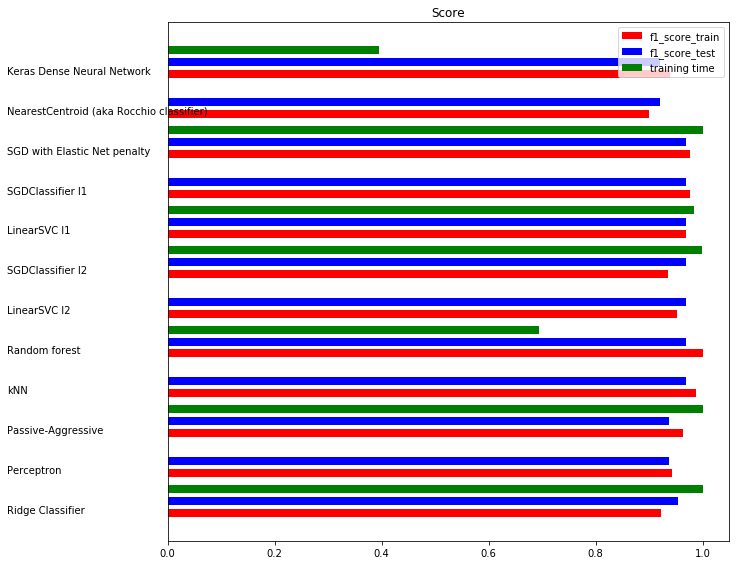

In [54]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, f1_score_train, f1_score_test, training_time = results

training_time = np.array(training_time) / np.max(training_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, f1_score_train, .2, label="f1_score_train", color='r')
plt.barh(indices+0.3, f1_score_test, .2, label="f1_score_test", color='b')
plt.barh(indices + .6, training_time, .2, label="training time", color='g')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, model_name):
    plt.text(-.3, i, c)

plt.show()

# The above results show the Precision and Accuracy of the 'No' cases is zero. On further inspection we find, the Yes/No is governed by a simple business rule, and most of the 'No' entries are data entry errors. There is only genuine 'No' entry in the file 'Lays BIO - FSHA - In Process 04.03.19 (002)'. We recommend a Business Rules based approach for this automation.